In [1]:
import os
import sys
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt

In [2]:
from matmul import linear_estimates, logit_estimates, attend_estimates
from norm import layer_norm_estimates
from pointwise import softmax_estimates, dropout_estimates, nonlinear_act_estimates
from time_projections import get_time_flops, get_time_mem, get_time_comm, get_topology, get_total_time

In [3]:
def compute_timings_and_stats(summary, system):
    ''' timings, any other df stats '''

    # which layers use tensor cores
    tensor_core_layers = ['fc1', 'fc2', 'qkv_proj', 'v_proj', 'logits', 'attend']
   
    # time for forward
    summary['t_comp_fwd'] = summary.apply(lambda x: get_time_flops(x["flops_fwd"], 
                                                                   use_tensor=(x["layer"] in tensor_core_layers),
                                                                   system=system), axis=1)
    summary['t_mem_fwd'] = summary.apply(lambda x: get_time_mem(x["total_mem_fwd"], system=system), axis=1)
    # time for backward
    summary['t_comp_bwd'] = summary.apply(lambda x: get_time_flops(x["flops_bwd"], 
                                                                   use_tensor=(x["layer"] in tensor_core_layers),
                                                                   system=system), axis=1)
    summary['t_mem_bwd'] = summary.apply(lambda x: get_time_mem(x["total_mem_bwd"], system=system), axis=1)
    
    # times
    summary['intensity'] = summary['t_comp_fwd'] / summary['t_mem_fwd']
    # roofline
    summary['t_fwd'] = summary.apply(lambda x: max(x['t_comp_fwd'], x['t_mem_fwd']), axis=1)
    summary['t_bwd'] = summary.apply(lambda x: max(x['t_comp_bwd'], x['t_mem_bwd']), axis=1)
    
    # time for communication
    use_empirical = False
    summary['comm_topology'] = summary.apply(lambda x: get_topology(x["comm_size"], system=system), axis=1)
    summary['t_comm_fwd'] = summary.apply(lambda x: get_time_comm(x["comm_fwd"],
                                                                  n_gpus=x["comm_size"],
                                                                  comm_type=x["comm_fwd_type"], 
                                                                  topology=x["comm_topology"],
                                                                  empirical=use_empirical,
                                                                  system=system), axis=1)
    summary['t_comm_bwd'] = summary.apply(lambda x: get_time_comm(x["comm_bwd"],
                                                                  n_gpus=x["comm_size"],
                                                                  comm_type=x["comm_bwd_type"], 
                                                                  topology=x["comm_topology"],
                                                                  empirical=use_empirical,
                                                                  system=system), axis=1)
    
    # total time
    summary['t_total_fwd'] = summary.apply(lambda x: get_total_time(x['t_fwd'], x['t_comm_fwd'], use_max=False), axis=1)
    summary['t_total_bwd'] = summary.apply(lambda x: get_total_time(x['t_bwd'], x['t_comm_bwd'], use_max=False), axis=1)
    
    # fraction
    summary['frac_t_comm_fwd'] = summary['t_comm_fwd'] / summary['t_total_fwd']
    summary['frac_t_comm_bwd'] = summary['t_comm_bwd'] / summary['t_total_bwd']

    return summary

In [4]:
#### nn modules ###
def MLP_estimates(b, l, e, f, depth, element_size=4E-6, mask_element_size=1E-6, flops_units=1E-12, parallelism={'m1': 1, 'm2': 1}, system={}):
    """
    MLP layer estimates
    parameters: b: batch size
                l: seq length
                e: embedding dim
                f: hidden dim
                element_size: in MB
                mask_element_size: in MB (for dropout)
    
    tensor shapes: input tensor: (b,l,e)
                   output tensor: (b,l,e)
                   
    layer arithmetic: 
        forward pass: 
             X = XW + b
             (b,l,f) = (b,l,e) * (e,f) + (1,f)
             X = nonlinear(X)
             (b,l,f) = (b,l,f)
             X = dropout(X)
             (b,l,f) = (b,l,f) * (b,l,f) [random mask]
             X = linear(X)
             (b,l,e) = (b,l,f) * (f,e) + (1,e)
             X = dropout(X)
             (b,l,e) = (b,l,e) * (b,l,e) [random mask]
            
        backward pass:
             chain rule
             
    parallelism:
            X = XW + b
            (b,l,f/m) = (b,l,e) * (e,f/m) + (1,f/m)
            X = nonlinear(X)
            (b,l,f/m) = (b,l,f/m)
            X = dropout(X)
            (b,l,f/m) = (b,l,f/m) * (b,l,f/m) [random mask]
            X = linear(X)
            (b,l,e/m) = (b,l,f/m) * (f/m,e) + (1,e)
            X = dropout(X)
            (b,l,e) = (b,l,e) * (b,l,e) [random mask]
            
    comments: 
    """
    
    summary = []
    
    m1 = parallelism['m1']
    m2 = 1 # parallelism['m2'] # not used in 1D parallelism (set to 1)
    
    m1_parallel = (m1 > 1)
    
    total_time = 0
    
    ######################################################################################################################################################
    ######################################################################################################################################################
        
    stats = linear_estimates(b, l, e, f // m1, element_size=element_size, has_bias=True, flops_units=flops_units)
    stats["layer"] = "fc1"   
    # sync/comm layers
    # no fwd comms
    stats["comm_bwd"] = m1_parallel * (b * l * e) * element_size # bwd comms for partial sums of b,l,e
    stats["comm_bwd_type"] = "reducescatter" 
    stats["comm_size"] = m1
    summary.append(stats)
    
    ######################################################################################################################################################
    ######################################################################################################################################################
    
    stats = nonlinear_act_estimates(b, l, f // m1, element_size=element_size, flops_units=flops_units)
    stats["layer"] = "act"
    summary.append(stats)
    
    ######################################################################################################################################################
    ######################################################################################################################################################
    
    stats = dropout_estimates(b, l, f // m1, element_size=element_size, mask_element_size=mask_element_size, flops_units=flops_units)
    stats["layer"] = "dpr1"
    summary.append(stats)
    
    ######################################################################################################################################################
    ######################################################################################################################################################
    
    stats = linear_estimates(b, l, f // m1, e, element_size=element_size, has_bias=True, flops_units=flops_units)
    stats["layer"] = "fc2"
    # sync/comm layers
    # no bwd comms
    stats["comm_fwd"] =  m1_parallel * (b * l * e) * element_size # fwd comms for partial sums of b,l,e
    stats["comm_fwd_type"] = "reducescatter"
    stats["comm_size"] = m1
    summary.append(stats)
    
    ######################################################################################################################################################
    ######################################################################################################################################################
    
    stats = dropout_estimates(b, l // m1, e, element_size=element_size, mask_element_size=mask_element_size, flops_units=flops_units)
    stats["layer"] = "dpr2"
    # sync/comm layers
    stats["comm_bwd"] = m1_parallel *  (b * l * e) * element_size
    stats["comm_bwd_type"] = "allgather"
    stats["comm_size"] = m1
    summary.append(stats)
    
    ######################################################################################################################################################
    ######################################################################################################################################################
    
    summary = pd.DataFrame(summary)
    summary = compute_timings_and_stats(summary, system)
    
    return summary
        

In [5]:
def self_attention_estimates(b, l, e, h, element_size=4E-6, mask_element_size=1E-6, flops_units=1E-12, parallelism={'m1': 1, 'm2': 1}, system={}):
    """
    dropout layer estimates
    parameters: b: batch size
                l: seq length
                e: embedding dim/hidden dim
                h: number of attention heads
                element_size: in MB
    
    tensor shapes: input tensor: (b,l,e)
                   output tensor: (b,l,e)
                   
    layer arithmetic: 
        define: q = e/h
        forward pass: 
             X = norm(X)
             Q = XW, K = XW, V = XW
             (b,l,h,q,3) = (b,l,e) * (e,3hq)
             A = QK'/sqrt(q)
             (b,h,l,l) = (b,h,l,q) * (b,h,q,l)
             A = softmax(A)
             (b,h,l,l) = (b,h,l,l)
             A = dpr(A)
             Y = AV
             (b,h,l,q) = (b,h,l,l) * (b,h,l,q)
             Y = VW
             (b,l,e) = (b,l,hq) * (hq,e)
             Y = dpr(Y)
             (b,l,e) = (b,l,e)
             Y = norm(Y)
             (b,l,e) = (b,l,e)
             
        backward pass:
             chain rule
             
        parallelism:
             X = norm(X)
             Q = XW, K = XW, V = XW
             (b,l,h/m,q,3) = (b,l,e) * (e,3hq/m)
             A = QK'/sqrt(q)
             (b,h/m,l,l) = (b,h/m,l,q) * (b,h/m,q,l)
             A = softmax(A)
             (b,h/m,l,l) = (b,h/m,l,l)
             A = dpr(A)
             (b,h/m,l,l) = (b,h/m,l,l)
             Y = AV
             (b,h/m,l,q) = (b,h/m,l,l) * (b,h/m,l,q)
             Y = VW
             (b,l,e) = (b,l,hq/m) * (hq/m,e)
             Y = dpr(Y)
             (b,l,e) = (b,l,e)
             Y = norm(Y)
             (b,l,e) = (b,l,e)
            
    
    comments: 
    """
    summary = []
    
    q = e // h
    
    m1 = parallelism['m1']
    m2 = 1 #parallelism['m2'] # 1D parallelism for now
    
    m1_parallel = (m1 > 1)
    
    ######################################################################################################################################################
    ######################################################################################################################################################
    
    stats = layer_norm_estimates(b, l // m1, e, element_size=element_size, flops_units=flops_units)
    stats["layer"] = "layer_norm_1"
    # sync/comm layers
    stats["comm_fwd"] = m1_parallel * (b * l * e) * element_size # all gather for the next op
    stats["comm_fwd_type"] = "allgather"
    stats["comm_size"] = m1
    summary.append(stats)
    
    ######################################################################################################################################################
    ######################################################################################################################################################
    
    stats = linear_estimates(b, l, e, (3*e) // m1, element_size=element_size, has_bias=False, flops_units=flops_units)
    stats["layer"] = "qkv_proj"
    # sync/comm layers: no fwd coms here
    stats["comm_bwd"] = m1_parallel * (b * l * e) * element_size # reduce scatter before going to ln: TODO check?
    stats["comm_bwd_type"] = "reducescatter"
    stats["comm_size"] = m1
    summary.append(stats)
    
    ######################################################################################################################################################
    ######################################################################################################################################################
    
    stats = logit_estimates(b, l, q, h // m1, element_size=element_size, flops_units=flops_units)
    stats["layer"] = "logits"
    summary.append(stats)
    ######################################################################################################################################################
    ######################################################################################################################################################
    
    stats = softmax_estimates(b, l, h // m1, element_size=element_size, flops_units=flops_units)
    stats["layer"] = "softmax"
    summary.append(stats)
    
    ######################################################################################################################################################
    ######################################################################################################################################################
    
    stats = dropout_estimates(b, l, (l*h) // m1, element_size=element_size, mask_element_size=mask_element_size, flops_units=flops_units)
    stats["layer"] = "dropout_softmax"
    summary.append(stats)
    
    ######################################################################################################################################################
    ######################################################################################################################################################

    stats = attend_estimates(b, l, q, h // m1, element_size=element_size, flops_units=flops_units)
    stats["layer"] = "attend"
    summary.append(stats)
    
    ######################################################################################################################################################
    ######################################################################################################################################################
    
    stats = linear_estimates(b, l, (h*q) // m1, e, element_size=element_size, has_bias=True, flops_units=flops_units)
    stats["layer"] = "v_proj"
    # sync/comm layers
    stats["comm_fwd"] = m1_parallel * (b * l * e) * element_size # fwd comms for partial sums of b,l,e
    stats["comm_fwd_type"] = "reducescatter"
    stats["comm_size"] = m1
    summary.append(stats)
    
    ######################################################################################################################################################
    ######################################################################################################################################################
    
    stats = dropout_estimates(b, l // m1, e, element_size=element_size, mask_element_size=mask_element_size, flops_units=flops_units)
    stats["layer"] = "dropout"
    # sync/comm layers
    stats["comm_bwd"] = m1_parallel * (b * l * e) * element_size
    stats["comm_bwd_type"] = "allgather"
    stats["comm_size"] = m1
    summary.append(stats)
    
    ######################################################################################################################################################
    ######################################################################################################################################################
    
    stats = layer_norm_estimates(b, l // m1, e, element_size=element_size, flops_units=flops_units)
    stats["layer"] = "layer_norm_2"
    # sync/comm layers
    stats["comm_fwd"] = m1_parallel * (b * l * e) * element_size # all gather for the next op
    stats["comm_fwd_type"] = "allgather"
    stats["comm_size"] = m1
    summary.append(stats)
    
    ######################################################################################################################################################
    ######################################################################################################################################################
    
    summary = pd.DataFrame(summary)
    summary = compute_timings_and_stats(summary, system)

    
    return summary

In [6]:
### model
pd.options.display.max_columns = None
pd.options.display.max_rows = None
b = 1
patch = 16
ih = 720
iw = 1440 
l = 2048 #ih // patch * iw // patch
e = 12288
f = 4 * e
h = 96
depth = 96
fp32_sz = 4E-9
fp16_sz = 2E-9
int_sz = 1E-9
flops_units = 1E-12 # teraflops

print("model: batch size = {}, seq length = {}, embed = {}, attention heads = {}, depth = {}".format(b, l, e, h, depth))

### model parallelism
parallelism = {'m1': 8,
               'm2': 1}
### system configs
system = {'matrix_flops_fp16': 312,
          'vector_flops_fp32': 19.5,
          'vector_flops_fp16': 78,
          'hbm_bandwidth': 1555,
          'nvlink_bandwidth': 600,
          'ib_bandwidth': 100,
          'hbm_latency': 0,
          'nvlink_latency': 0,
          'ib_latency': 0,
          'nvlink_size': 0}
print("parallelization: m1 = {}, m2 = {}".format(parallelism['m1'], parallelism['m2']))

# MLP
df_mlp = MLP_estimates(b, l, e, f, depth, element_size=fp16_sz, mask_element_size=int_sz, flops_units=flops_units, 
                       parallelism=parallelism, system=system)
cols = df_mlp.columns.tolist()
cols.remove('layer')
cols = ['layer'] + cols

# self attention
df_sa = self_attention_estimates(b, l, e, h, element_size=fp16_sz, mask_element_size=int_sz, flops_units=flops_units, 
                                 parallelism=parallelism, system=system)

# sum these columns (mem in buffer: activation buffers, weights, weights_grads, total flops, timings)
layer_track_cols = ['activation_buffer', 'weights_mem', 
                    'weights_grad_mem', 'flops_fwd', 'flops_bwd', 
                    't_total_fwd', 't_total_bwd', 't_comm_fwd', 't_comm_bwd']

print('\n************** MLP layer estimates **************\n')
display(df_mlp[cols])
display(df_mlp[layer_track_cols].sum() * depth)
t_f = df_mlp['t_total_fwd'].sum()
t_c = df_mlp['t_comm_fwd'].sum()
print('time spend in comms = {}'.format(t_c / t_f))

print('\n************** SA layer estimates **************\n')
display(df_sa[cols])
display(df_sa[layer_track_cols].sum() * depth)
t_f = df_sa['t_total_fwd'].sum()
t_c = df_sa['t_comm_fwd'].sum()
print('time spend in comms = {}'.format(t_c / t_f))

model: batch size = 1, seq length = 2048, embed = 12288, attention heads = 96, depth = 96
parallelization: m1 = 8, m2 = 1

************** MLP layer estimates **************



,layer,flops_fwd,activation_in_mem,activation_in_other_mem,activation_out_mem,activation_buffer,weights_mem,total_mem_fwd,flops_bwd,activation_grad_mem,weights_grad_mem,total_mem_bwd,comm_bwd,comm_bwd_type,comm_size,comm_fwd,comm_fwd_type,t_comp_fwd,t_mem_fwd,t_comp_bwd,t_mem_bwd,intensity,t_fwd,t_bwd,comm_topology,t_comm_fwd,t_comm_bwd,t_total_fwd,t_total_bwd,frac_t_comm_fwd,frac_t_comm_bwd
0,fc1,0.309238,0.050332,0.000000,0.025166,0.050332,0.151007,0.226505,0.618387,0.075497,0.151007,0.427844,0.050332,reducescatter,8.0,NaN,NaN,0.991146,0.145662,1.982010,0.275141,6.804417,0.991146,1.982010,ib,0.000000,0.503316,0.991146,2.485327,0.000000,0.202515
1,act,0.000013,0.025166,0.000000,0.025166,0.025166,0.000000,0.050332,0.000013,0.050332,0.000000,0.075497,NaN,NaN,NaN,NaN,NaN,0.000161,0.032368,0.000161,0.048551,0.004984,0.032368,0.048551,None,0.000000,0.000000,0.032368,0.048551,0.000000,0.000000
2,dpr1,0.000013,0.025166,0.012583,0.025166,0.012583,0.000000,0.062915,0.000013,0.050332,0.000000,0.062915,NaN,NaN,NaN,NaN,NaN,0.000161,0.040460,0.000161,0.040460,0.003987,0.040460,0.040460,None,0.000000,0.000000,0.040460,0.040460,0.000000,0.000000
3,fc2,0.309238,0.025166,0.000000,0.050332,0.025166,0.151020,0.226517,0.618412,0.075497,0.151020,0.402702,NaN,NaN,8.0,0.050332,reducescatter,0.991146,0.145670,1.982091,0.258973,6.804048,0.991146,1.982091,ib,0.503316,0.000000,1.494463,1.982091,0.336788,0.000000
4,dpr2,0.000003,0.006291,0.003146,0.006291,0.003146,0.000000,0.015729,0.000003,0.012583,0.000000,0.015729,0.050332,allgather,8.0,NaN,NaN,0.000040,0.010115,0.000040,0.010115,0.003987,0.010115,0.010115,ib,0.000000,0.503316,0.010115,0.513431,0.000000,0.980299


activation_buffer     11.173626
weights_mem           28.994568
weights_grad_mem      28.994568
flops_fwd             59.376346
flops_bwd            118.735478
t_total_fwd          246.580906
t_total_bwd          486.706563
t_comm_fwd            48.318382
t_comm_bwd            96.636764
dtype: float64

time spend in comms = 0.19595346165869787

************** SA layer estimates **************



,layer,flops_fwd,activation_in_mem,activation_in_other_mem,activation_out_mem,activation_buffer,weights_mem,total_mem_fwd,flops_bwd,activation_grad_mem,weights_grad_mem,total_mem_bwd,comm_bwd,comm_bwd_type,comm_size,comm_fwd,comm_fwd_type,t_comp_fwd,t_mem_fwd,t_comp_bwd,t_mem_bwd,intensity,t_fwd,t_bwd,comm_topology,t_comm_fwd,t_comm_bwd,t_total_fwd,t_total_bwd,frac_t_comm_fwd,frac_t_comm_bwd
0,layer_norm_1,0.000028,0.006291,0.000001,0.006291,0.006291,0.000049,0.012633,0.000041,0.012583,0.000049,0.018924,NaN,NaN,8.0,0.050332,allgather,0.000363,0.008124,0.000524,0.012169,0.044678,0.008124,0.012169,ib,0.503316,0.000000,0.511441,0.012169,0.984115,0.000000
1,qkv_proj,0.231919,0.050332,0.000000,0.018874,0.050332,0.113246,0.182452,0.463775,0.069206,0.113246,0.346030,0.050332,reducescatter,8.0,NaN,NaN,0.743329,0.117333,1.486457,0.222527,6.335233,0.743329,1.486457,ib,0.000000,0.503316,0.743329,1.989774,0.000000,0.252952
2,logits,0.012835,0.006291,0.006291,0.100663,0.012583,0.000000,0.113246,0.025764,0.113246,0.000000,0.125829,NaN,NaN,NaN,NaN,NaN,0.041136,0.072827,0.082575,0.080919,0.564850,0.072827,0.082575,None,0.000000,0.000000,0.072827,0.082575,0.000000,0.000000
3,softmax,0.000151,0.100663,0.000000,0.100663,0.100663,0.000000,0.201327,0.000201,0.201327,0.000000,0.301990,NaN,NaN,NaN,NaN,NaN,0.001936,0.129470,0.002581,0.194206,0.014949,0.129470,0.194206,None,0.000000,0.000000,0.129470,0.194206,0.000000,0.000000
4,dropout_softmax,0.000050,0.100663,0.050332,0.100663,0.050332,0.000000,0.251658,0.000050,0.201327,0.000000,0.251658,NaN,NaN,NaN,NaN,NaN,0.000645,0.161838,0.000645,0.161838,0.003987,0.161838,0.161838,None,0.000000,0.000000,0.161838,0.161838,0.000000,0.000000
5,attend,0.012882,0.100663,0.006291,0.006291,0.106955,0.000000,0.113246,0.025716,0.113246,0.000000,0.220201,NaN,NaN,NaN,NaN,NaN,0.041288,0.072827,0.082424,0.141608,0.566927,0.072827,0.141608,None,0.000000,0.000000,0.072827,0.141608,0.000000,0.000000
6,v_proj,0.077309,0.006291,0.000000,0.050332,0.006291,0.037773,0.094396,0.154622,0.056623,0.037773,0.138461,NaN,NaN,8.0,0.050332,reducescatter,0.247787,0.060705,0.495583,0.089043,4.081809,0.247787,0.495583,ib,0.503316,0.000000,0.751103,0.495583,0.670103,0.000000
7,dropout,0.000003,0.006291,0.003146,0.006291,0.003146,0.000000,0.015729,0.000003,0.012583,0.000000,0.015729,0.050332,allgather,8.0,NaN,NaN,0.000040,0.010115,0.000040,0.010115,0.003987,0.010115,0.010115,ib,0.000000,0.503316,0.010115,0.513431,0.000000,0.980299
8,layer_norm_2,0.000028,0.006291,0.000001,0.006291,0.006291,0.000049,0.012633,0.000041,0.012583,0.000049,0.018924,NaN,NaN,8.0,0.050332,allgather,0.000363,0.008124,0.000524,0.012169,0.044678,0.008124,0.012169,ib,0.503316,0.000000,0.511441,0.012169,0.984115,0.000000


activation_buffer     32.916898
weights_mem           14.507311
weights_grad_mem      14.507311
flops_fwd             32.179738
flops_bwd             64.340453
t_total_fwd          284.581591
t_total_bwd          345.922062
t_comm_fwd           144.955146
t_comm_bwd            96.636764
dtype: float64

time spend in comms = 0.5093623431108953


In [7]:
def plot(n_gpus, parallelism, system, axs, lgnd=['MLP', 'SA'], lfmt="-"):
    t_frac_mlp = []
    t_frac_sa = []

    t_mlp_c = []
    t_sa_c = []

    t_mlp_comm = []
    t_sa_comm = []

    for n in n_gpus:
        parallelism['m1'] = n
        parallelism['m2'] = 1

        df_mlp = MLP_estimates(b, l, e, f, depth, element_size=fp16_sz, mask_element_size=int_sz, flops_units=flops_units, 
                               parallelism=parallelism, system=system)
        df_sa = self_attention_estimates(b, l, e, h, element_size=fp16_sz, mask_element_size=int_sz, flops_units=flops_units, 
                                     parallelism=parallelism, system=system)
        t_f = df_mlp['t_total_fwd'].sum()
        t_c = df_mlp['t_comm_fwd'].sum()
        t_mlp_c.append(t_f)
        t_mlp_comm.append(t_c)
        t_frac_mlp.append(t_c / t_f)

        t_f = df_sa['t_total_fwd'].sum()
        t_c = df_sa['t_comm_fwd'].sum()
        t_sa_c.append(t_f)
        t_sa_comm.append(t_c)
        t_frac_sa.append(t_c / t_f)


    ax = axs[0]
    ax.plot(n_gpus, t_frac_mlp, lfmt, linewidth=2, c=c1)
    ax.plot(n_gpus, t_frac_sa, lfmt, linewidth=2, c=c2)
    ax.set_xlabel('Number of GPUs', fontsize=fsz)
    ax.set_xticks(n_gpus)
    ax.legend(lgnd, fontsize=fsz-4)
    # ax.set_xscale('log')
    ax.set_xticklabels(n_gpus, fontsize=fsz-4)
    ax.set_ylabel('Fraction of time in comms', fontsize=fsz)
    ax.set_yticks([0,0.2,0.4,0.6,0.8,1])
    ax.set_yticklabels([0,0.2,0.4,0.6,0.8,1], fontsize=fsz-4)

    ax = axs[1]
    ax.plot(n_gpus, t_mlp_c, lfmt, linewidth=2, c=c1)
    ax.plot(n_gpus, t_sa_c, lfmt, linewidth=2, c=c2)
    ax.set_xlabel('Number of GPUs', fontsize=fsz)
    ax.set_xticks(n_gpus)
    ax.set_xticklabels(n_gpus, fontsize=fsz-4)
    ax.set_ylabel('Total time', fontsize=fsz)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.legend(lgnd, fontsize=fsz-4)

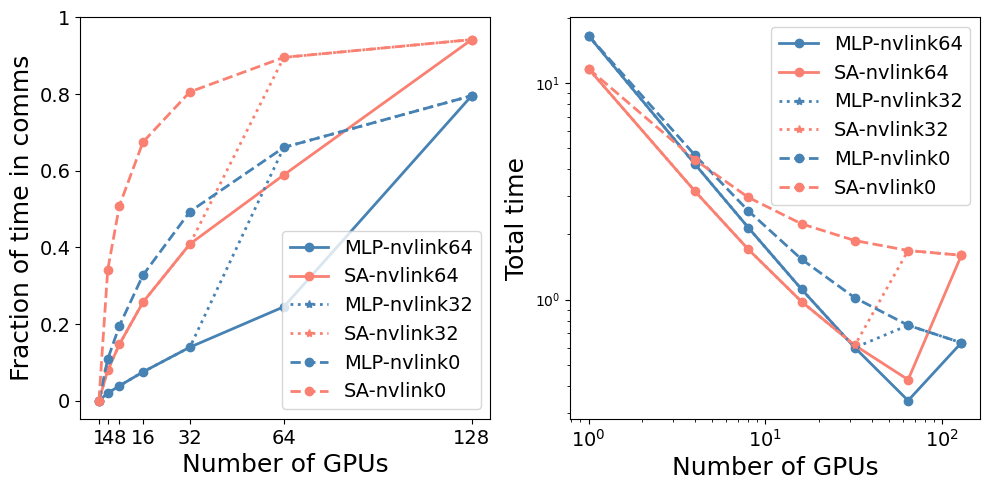

In [8]:
# Sweeps
### model parallelism
n_gpus = [1, 4, 8, 16, 32, 64, 128]
parallelism = {'m1': 1,
               'm2': 1}
system = {'matrix_flops_fp16': 312,
          'vector_flops_fp32': 19.5,
          'vector_flops_fp16': 78,
          'hbm_bandwidth': 1555,
          'nvlink_bandwidth': 600,
          'ib_bandwidth': 100,
          'nvlink_size': 8}

fig, axs = plt.subplots(1,2,figsize=(10,5), tight_layout=True) 
c1 = 'steelblue'
c2 = 'salmon'
fsz = 18

nvs = 64
system['nvlink_size'] = nvs
lgnd = ["MLP-nvlink{}".format(nvs), "SA-nvlink{}".format(nvs)]
plot(n_gpus, parallelism, system, axs, lgnd=lgnd, lfmt="o-")
nvs = 32
system['nvlink_size'] = nvs
lgnd += ["MLP-nvlink{}".format(nvs), "SA-nvlink{}".format(nvs)]
plot(n_gpus, parallelism, system, axs, lgnd=lgnd, lfmt="*:")
system['nvlink_size'] = 0
lgnd += ["MLP-nvlink0", "SA-nvlink0"]
plot(n_gpus, parallelism, system, axs, lgnd=lgnd, lfmt="o--")